<a href="https://colab.research.google.com/github/VladislavTumanov/bookish-computing-machine/blob/main/OilProduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import requests
import io 
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import tree
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge, LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import xgboost as xgb
from sklearn.preprocessing import PolynomialFeatures, StandardScaler,MinMaxScaler

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving production_data.txt to production_data.txt


In [ ]:
def delete_nan(table):
  for col in table.columns:
    table[col] = table[col].fillna(table[col].median())
  return table

In [ ]:
production_data = pd.read_csv((io.BytesIO(uploaded['production_data.txt'])), delimiter = ',')
production_data

,Lease,Time (Days),Choke Size,Gas Volume (MMscf),Oil Volume (stb),Water Volume (stb),Gas Lift Inj Volume (MMscf),Casing Pressure (psi(a)),Tubing Pressure (psi(a)),Active Pressure (psi(a)),Line Pressure (psi(a)),Pressure Source,Calculated Sandface Pressure (psi(a))
0,OSPREY,1.0,NaN,0.145,504.39,718.0,NaN,2064.695943,14.695943,2064.695943,14.695943,Casing Pressure,5050.159793
1,OSPREY,2.0,NaN,0.186,564.76,922.0,NaN,1989.695943,14.695943,1989.695943,14.695943,Casing Pressure,5009.599839
2,OSPREY,3.0,NaN,0.231,653.51,753.0,NaN,1864.695943,14.695943,1864.695943,14.695943,Casing Pressure,4795.991972
3,OSPREY,4.0,NaN,0.268,740.71,700.0,NaN,1814.695943,14.695943,1814.695943,14.695943,Casing Pressure,4696.626023
4,OSPREY,5.0,NaN,0.261,678.06,530.0,NaN,1714.695943,14.695943,1714.695943,14.695943,Casing Pressure,4546.990059
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60962,GOOSE,2842.0,NaN,0.000,0.00,0.0,NaN,1724.502000,-0.755000,-0.755000,1.723000,Tubing Pressure,NaN
60963,GOOSE,2843.0,NaN,0.000,0.00,0.0,NaN,1723.853000,-0.111000,-0.111000,2.343000,Tubing Pressure,NaN
60964,GOOSE,2844.0,NaN,0.000,0.00,0.0,NaN,1723.499000,-0.398000,-0.398000,1.099000,Tubing Pressure,NaN
60965,GOOSE,2845.0,NaN,0.000,0.00,0.0,NaN,1722.222000,-0.555000,-0.555000,0.633000,Tubing Pressure,NaN


# Preprocessing dataset

In [ ]:
production_data.columns

Index(['Lease', 'Time (Days)', 'Choke Size', 'Gas Volume (MMscf)',
       'Oil Volume (stb)', 'Water Volume  (stb)',
       'Gas Lift Inj Volume  (MMscf)', 'Casing Pressure  (psi(a))',
       'Tubing Pressure  (psi(a))', 'Active Pressure  (psi(a))',
       'Line Pressure  (psi(a))', 'Pressure Source ',
       'Calculated Sandface Pressure  (psi(a))'],
      dtype='object')

In [ ]:
for i in ['Pressure Source ', 'Lease']:
  print(i, np.unique(production_data[i]))

Pressure Source  ['Casing Pressure' 'Tubing Pressure']
Lease ['ALBATROSS' 'ARCHAEOPTERYX' 'AVOCET' 'BEE-EATER' 'BLUEBIRD' 'CANARY'
 'CARDINAL' 'CASSOWARY' 'CRANE' 'CROW' 'CUCKOO' 'DUCK' 'EAGLE' 'EGRET'
 'EMU' 'FALCON' 'FINCH' 'FLAMINGO' 'GOOSE' 'HARPY' 'HAWK' 'HERON'
 'HUMMINGBIRD' 'IBIS' 'JAY' 'KITE' 'LARK' 'LOON' 'LORIKEET' 'MACAW'
 'MYNAH' 'ORIOLE' 'OSPREY' 'OSTRICH' 'OWL' 'PARROT' 'PARTRIDGE' 'PEACOCK'
 'PELICAN' 'PENGUIN' 'PHEASANT' 'PHOENIX' 'ROBIN' 'ROOSTER' 'SEAGULL'
 'SPARROW' 'STILT' 'STORK' 'SWAN' 'SWIFT' 'TERN' 'TOUCAN' 'WARBLER']


In [ ]:
production_data.describe()

,Time (Days),Choke Size,Gas Volume (MMscf),Oil Volume (stb),Water Volume (stb),Gas Lift Inj Volume (MMscf),Casing Pressure (psi(a)),Tubing Pressure (psi(a)),Active Pressure (psi(a)),Line Pressure (psi(a)),Calculated Sandface Pressure (psi(a))
count,60967.000000,2288.000000,60748.000000,52537.000000,60958.000000,7651.000000,60967.000000,60967.000000,60967.000000,60967.000000,60137.000000
mean,852.282382,27.877185,5.982365,36.450496,77.349569,0.219279,1283.679384,759.501393,1390.495107,696.823718,2299.493810
std,824.906531,9.385130,7.607748,105.729334,149.923524,0.158324,1514.521635,899.819732,1465.415127,412.611400,1833.520500
min,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000,-14.650000,-14.650000,-14.650000,0.000000,6.780602
25%,255.000000,22.000000,0.235618,0.000000,1.800000,0.000000,254.178000,0.000000,671.849500,405.369500,1161.582338
50%,574.000000,26.000000,3.878150,0.000000,9.625000,0.294000,891.922000,701.079000,972.141000,823.305000,1572.866109
75%,1178.000000,32.000000,8.115673,0.000000,78.000000,0.350000,1327.225500,1095.000000,1350.579000,1048.623500,2640.255039
max,4031.000000,48.000000,61.548720,1249.000000,2287.000000,0.532000,10239.180000,8499.389000,8700.180000,1310.234000,11093.735289


In [ ]:
production_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60967 entries, 0 to 60966
Data columns (total 13 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Lease                                   60967 non-null  object 
 1   Time (Days)                             60967 non-null  float64
 2   Choke Size                              2288 non-null   float64
 3   Gas Volume (MMscf)                      60748 non-null  float64
 4   Oil Volume (stb)                        52537 non-null  float64
 5   Water Volume  (stb)                     60958 non-null  float64
 6   Gas Lift Inj Volume  (MMscf)            7651 non-null   float64
 7   Casing Pressure  (psi(a))               60967 non-null  float64
 8   Tubing Pressure  (psi(a))               60967 non-null  float64
 9   Active Pressure  (psi(a))               60967 non-null  float64
 10  Line Pressure  (psi(a))                 60967 non-null  fl

<AxesSubplot:>

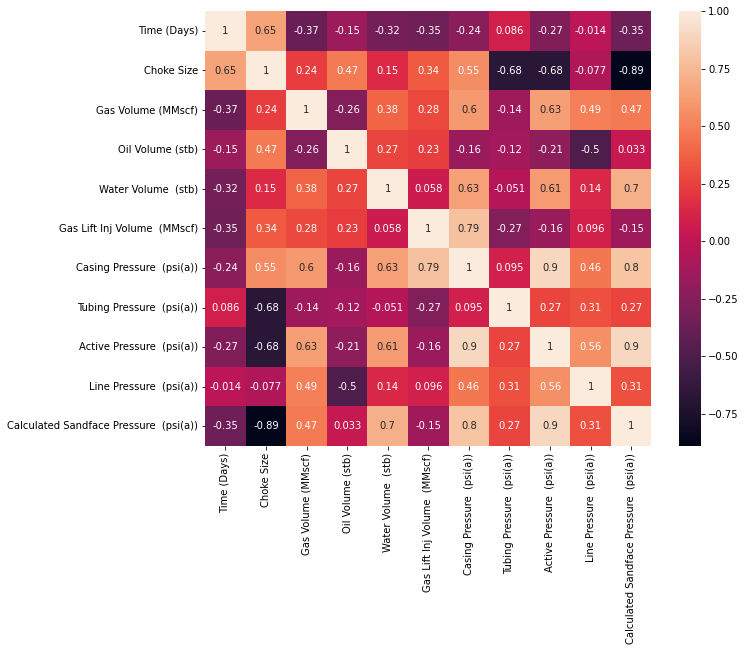

In [ ]:
fig, ax = plt.subplots(figsize = (10,8))
sns.heatmap(production_data.corr(), annot = True, ax = ax)

In [ ]:
production_data.isnull().sum()

Lease                                         0
Time (Days)                                   0
Choke Size                                58679
Gas Volume (MMscf)                          219
Oil Volume (stb)                           8430
Water Volume  (stb)                           9
Gas Lift Inj Volume  (MMscf)              53316
Casing Pressure  (psi(a))                     0
Tubing Pressure  (psi(a))                     0
Active Pressure  (psi(a))                     0
Line Pressure  (psi(a))                       0
Pressure Source                               0
Calculated Sandface Pressure  (psi(a))      830
dtype: int64

In [ ]:
# Сreating dummy variables to solve the regression task
production_data = pd.get_dummies(production_data, columns = ['Pressure Source '])

In [ ]:
production_data

,Lease,Time (Days),Choke Size,Gas Volume (MMscf),Oil Volume (stb),Water Volume (stb),Gas Lift Inj Volume (MMscf),Casing Pressure (psi(a)),Tubing Pressure (psi(a)),Active Pressure (psi(a)),Line Pressure (psi(a)),Calculated Sandface Pressure (psi(a)),Pressure Source _Casing Pressure,Pressure Source _Tubing Pressure
0,OSPREY,1.0,NaN,0.145,504.39,718.0,NaN,2064.695943,14.695943,2064.695943,14.695943,5050.159793,1,0
1,OSPREY,2.0,NaN,0.186,564.76,922.0,NaN,1989.695943,14.695943,1989.695943,14.695943,5009.599839,1,0
2,OSPREY,3.0,NaN,0.231,653.51,753.0,NaN,1864.695943,14.695943,1864.695943,14.695943,4795.991972,1,0
3,OSPREY,4.0,NaN,0.268,740.71,700.0,NaN,1814.695943,14.695943,1814.695943,14.695943,4696.626023,1,0
4,OSPREY,5.0,NaN,0.261,678.06,530.0,NaN,1714.695943,14.695943,1714.695943,14.695943,4546.990059,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60962,GOOSE,2842.0,NaN,0.000,0.00,0.0,NaN,1724.502000,-0.755000,-0.755000,1.723000,NaN,0,1
60963,GOOSE,2843.0,NaN,0.000,0.00,0.0,NaN,1723.853000,-0.111000,-0.111000,2.343000,NaN,0,1
60964,GOOSE,2844.0,NaN,0.000,0.00,0.0,NaN,1723.499000,-0.398000,-0.398000,1.099000,NaN,0,1
60965,GOOSE,2845.0,NaN,0.000,0.00,0.0,NaN,1722.222000,-0.555000,-0.555000,0.633000,NaN,0,1


In [ ]:
production_data.drop(columns = ['Gas Lift Inj Volume  (MMscf)', 'Choke Size', 'Gas Volume (MMscf)', 'Lease'],axis = 1, inplace = True)
production_data = delete_nan(production_data)
# the columns Gas lift volume (Msc) and Choke Size are deleted, since the data from there is not informative due to the large number of missing values
# We can build a model, take either the volume of oil or gas produced as the target variable. Let's take oil in this case by removing the gas column

In [ ]:
production_data

,Time (Days),Oil Volume (stb),Water Volume (stb),Casing Pressure (psi(a)),Tubing Pressure (psi(a)),Active Pressure (psi(a)),Line Pressure (psi(a)),Calculated Sandface Pressure (psi(a)),Pressure Source _Casing Pressure,Pressure Source _Tubing Pressure
0,1.0,504.39,718.0,2064.695943,14.695943,2064.695943,14.695943,5050.159793,1,0
1,2.0,564.76,922.0,1989.695943,14.695943,1989.695943,14.695943,5009.599839,1,0
2,3.0,653.51,753.0,1864.695943,14.695943,1864.695943,14.695943,4795.991972,1,0
3,4.0,740.71,700.0,1814.695943,14.695943,1814.695943,14.695943,4696.626023,1,0
4,5.0,678.06,530.0,1714.695943,14.695943,1714.695943,14.695943,4546.990059,1,0
...,...,...,...,...,...,...,...,...,...,...
60962,2842.0,0.00,0.0,1724.502000,-0.755000,-0.755000,1.723000,1572.866109,0,1
60963,2843.0,0.00,0.0,1723.853000,-0.111000,-0.111000,2.343000,1572.866109,0,1
60964,2844.0,0.00,0.0,1723.499000,-0.398000,-0.398000,1.099000,1572.866109,0,1
60965,2845.0,0.00,0.0,1722.222000,-0.555000,-0.555000,0.633000,1572.866109,0,1


<AxesSubplot:>

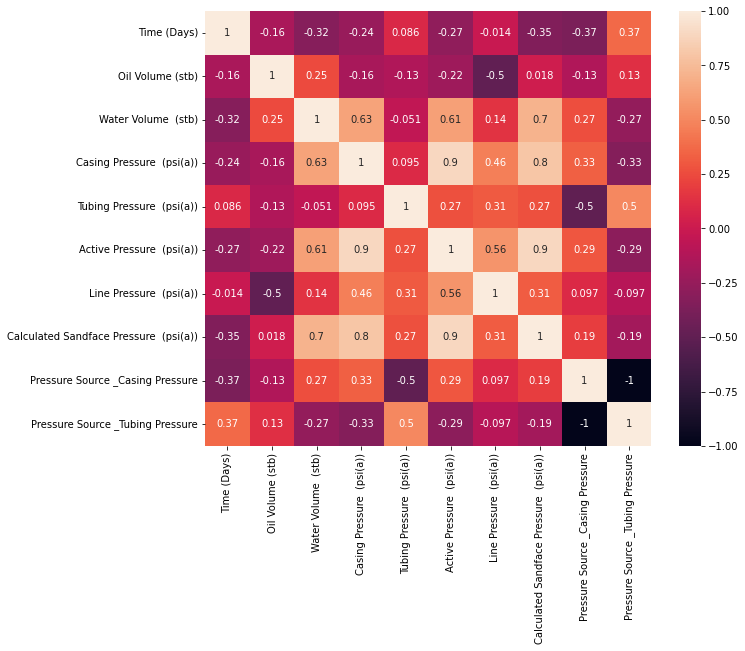

In [ ]:
fig, ax = plt.subplots(figsize = (10,8))
sns.heatmap(production_data.corr(), annot = True, ax = ax)

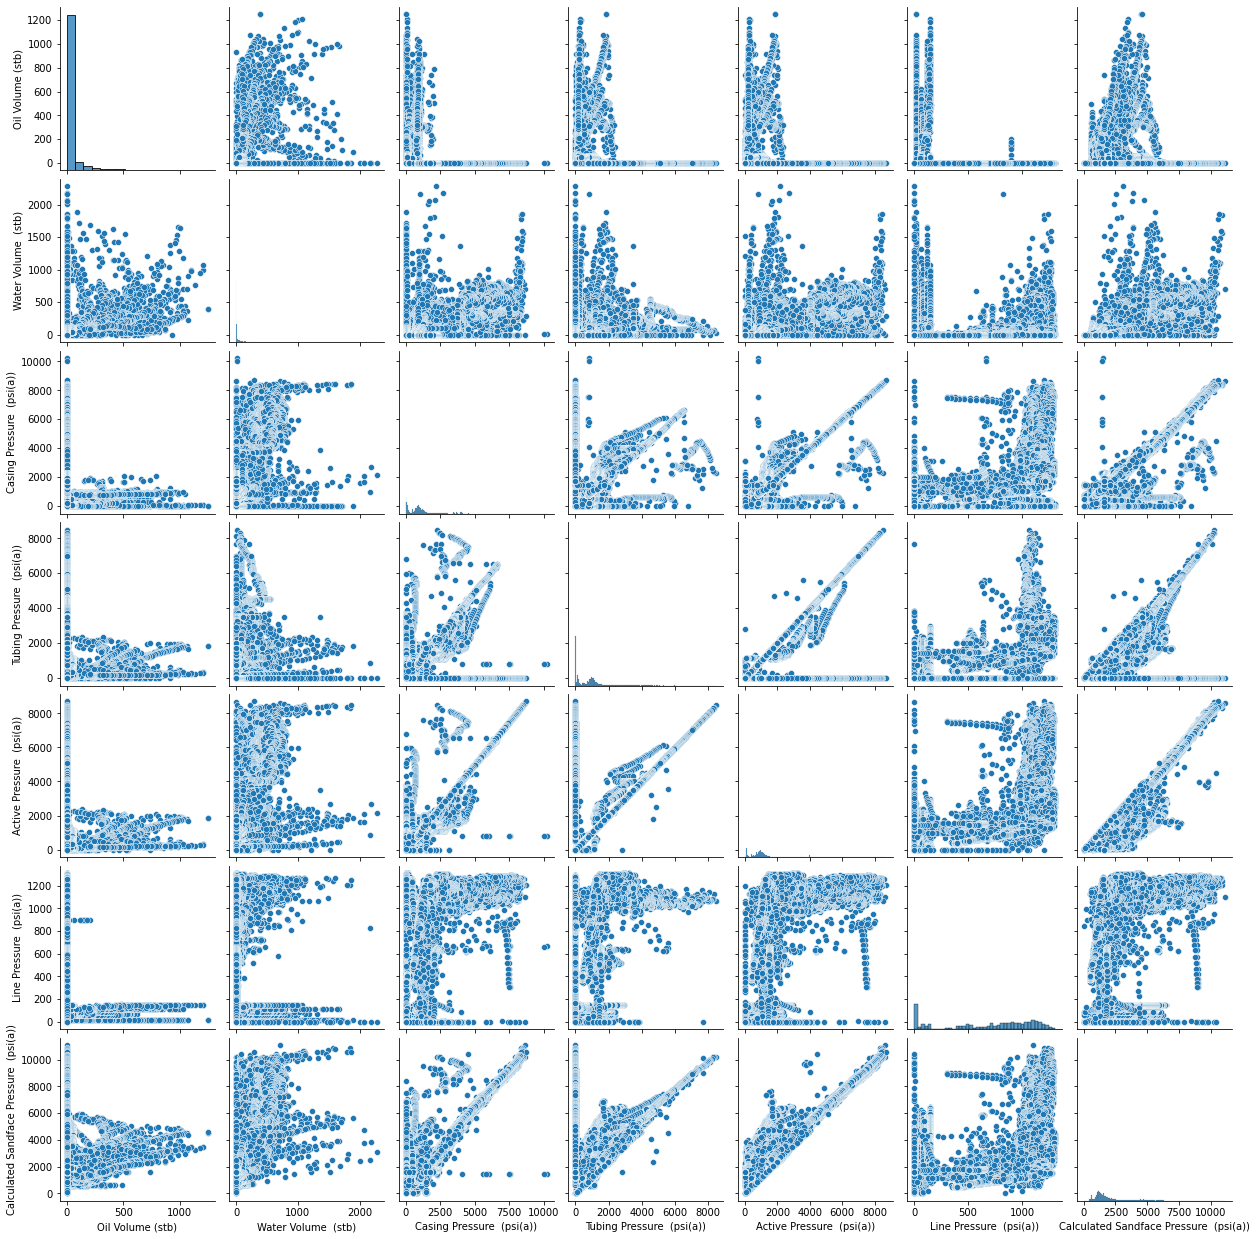

In [ ]:
col = production_data.columns[1:8]
sns.pairplot(production_data[col])

In [ ]:
X = production_data.drop('Oil Volume (stb)',axis = 1)
y = production_data['Oil Volume (stb)'] # as target value, we take 'Oil volume (stb)' column

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaler = scaler.transform(X_train)
X_test_scaler = scaler.transform(X_test)

# poly = PolynomialFeatures(degree=2)
# poly.fit(X_train_scaler)
# X_train_poly = poly.transform(X_train_scaler)
# X_test_poly = poly.transform(X_test_scaler)

# Ridge model 

In [ ]:
ridge = Ridge(random_state = 42)
params = {'alpha':[0.001,0.01,0.1,1,10,100], 'max_iter':[10000, 15000, 20000,25000,30000,35000]}

grid = GridSearchCV(ridge, params, cv = 4, n_jobs = -1)
grid.fit(X_train_scaler, y_train)
#We use GridSearchCV to determine the best combination of parameters from a given list

print('The best score in Ridge is:', grid.best_score_)
print('The best estimator in Ridge is:', grid.best_params_)

The best score in Ridge is: 0.42593869309298615
The best estimator in Ridge is: {'alpha': 10, 'max_iter': 10000}


In [ ]:
ridge = Ridge(random_state = 42,alpha=10, max_iter=10000 )
ridge.fit(X_train_scaler, y_train)
prediction = ridge.predict(X_test_scaler)

metrics = mean_squared_error(y_test, prediction)
print('mean_squared_error on the test is:', metrics)
print('R2-score is:', r2_score(y_test, prediction))

mean_squared_error on the test is: 5511.165096065365
R2-score is: 0.4349633896669576


In [ ]:
pd.DataFrame({'features' : X_train.columns, 'coef': ridge.coef_.flatten().tolist()}).sort_values(by = 'coef',  ascending=False)
#Using Ridge model, as we can see, feature which the most fluent on Oil Production is Water Volume (stb)

,features,coef
1,Water Volume (stb),40.460098
6,Calculated Sandface Pressure (psi(a)),32.453404
8,Pressure Source _Tubing Pressure,7.424403
3,Tubing Pressure (psi(a)),-1.197150
2,Casing Pressure (psi(a)),-3.911659
7,Pressure Source _Casing Pressure,-7.424403
0,Time (Days),-12.221760
5,Line Pressure (psi(a)),-32.093286
4,Active Pressure (psi(a)),-52.472596


# RandomForestRegressor

In [ ]:
forest = RandomForestRegressor(random_state = 42)
params1 = {
    'n_estimators': [80, 100,120],
    'min_samples_split':[2, 4],
    'min_samples_leaf': [1, 3],
    'max_depth': [3, 5]
    }

grid1 = GridSearchCV(forest, params1, cv = 4, n_jobs = -1)
grid1.fit(X_train, y_train)

In [ ]:
print('The best score in forest is:', grid1.best_score_)
print('The best estimator in forest is:', grid1.best_estimator_)

The best score in forest is: 0.7890374905248436
The best estimator in forest is: RandomForestRegressor(max_depth=5, n_estimators=120, random_state=42)


In [ ]:
forest = RandomForestRegressor(random_state = 42,max_depth=5, n_estimators=120)
forest.fit(X_train, y_train)
prediction1 = forest.predict(X_test)

metrics1 = mean_squared_error(y_test, prediction1)
print('mean_squared_error on the test is:', metrics1)
print('R2-score is:', r2_score(y_test, prediction1))

mean_squared_error on the test is: 2027.8625672415521
R2-score is: 0.7920917680304169


In [ ]:
importance = pd.DataFrame({'feature':X_train.columns, 'importance':np.round(forest.feature_importances_,3)})
importance
#Using RandomForestRegressor model, as we can see, feature which the most fluent on Oil Production is Tubing Pressure (psi(a))

,feature,importance
0,Time (Days),0.043
1,Water Volume (stb),0.326
2,Casing Pressure (psi(a)),0.004
3,Tubing Pressure (psi(a)),0.101
4,Active Pressure (psi(a)),0.008
5,Line Pressure (psi(a)),0.490
6,Calculated Sandface Pressure (psi(a)),0.029
7,Pressure Source _Casing Pressure,0.000
8,Pressure Source _Tubing Pressure,0.000


# XGBoost

In [ ]:
# Convert the data to DMatrix format for XGBoost to optimizes the memory usage and computation speed
dtrain = xgb.DMatrix(X_train_scaler, label = y_train)
dtest = xgb.DMatrix(X_test_scaler, label = y_test)

In [ ]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')

In [ ]:
# Define the XGBoost parameters
params = {
    'max_depth':[3, 4, 5],
    'learning_rate':[0.1, 0.01, 0.001],
    'n_estimators' : [50,100,200]
}

In [ ]:
grid_search = GridSearchCV(xgb_model, param_grid=params, cv=5, n_jobs=-1)
grid_search.fit(X_train_scaler, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [50, 100, 200]})

In [ ]:
# Define best parameters of XGBoost model
print(grid_search.best_params_)

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


In [ ]:
# Define best estimator of XGBoost model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaler)

In [ ]:
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
# That is, the resulting XGBoost will predict oil production depending on the parametrs with mean squared error approximately equal 366
# In the next steps we will be able to see that this is the most effective model for purposes

Mean Squared Error: 366.1286390911711


Text(0.5, 1.0, 'XGBoost Regression Model')

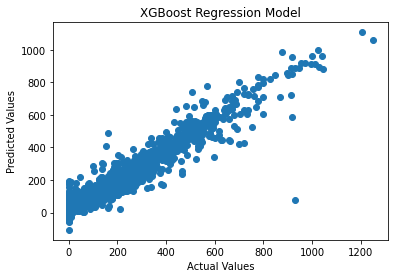

In [ ]:
plt.scatter(y_test,y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('XGBoost Regression Model')

Text(0.5, 1.0, 'XGBoost Feature Importances')

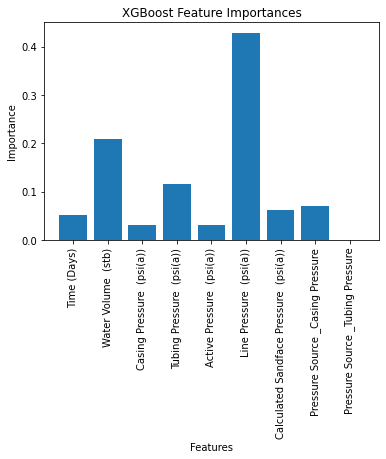

In [ ]:
importance = best_model.feature_importances_
plt.bar(range(len(importance)), importance)
plt.xticks(range(len(importance)), X_train.columns, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('XGBoost Feature Importances')
# Using XGBoost model we get impotrance distibution. the most significant feature is Line Pressure

# Build model using Neural Network

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaler = scaler.transform(X_train)
X_test_scaler = scaler.transform(X_test)

In [ ]:
rows, col = X_train_scaler.shape[0], X_train_scaler.shape[1]

In [ ]:
# Define structure of neural network
model = Sequential()

model.add(Dense(64, activation = 'relu', kernel_regularizer = regularizers.l2(0.01), input_shape = (col, )))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(32, activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1, activation = 'linear'))

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 64)                640       
                                                                 
 batch_normalization_8 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 32)                2080      
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                      

In [ ]:
# Define loss function, method of optimizer and metrics, that will tell us about quality of the model
model.compile(
    loss = 'mean_squared_error', 
    optimizer='adam',
    metrics = ['mse']
)

In [ ]:
train_attempt = model.fit(X_train_scaler,
                          y_train, epochs = 50, 
                          batch_size = 32, 
                          validation_data=(X_test_scaler, y_test))

Epoch 1/50
1429/1429 [==============================] - 9s 5ms/step - loss: 5414.7910 - mse: 5413.7070 - val_loss: 3710.2781 - val_mse: 3708.9399
Epoch 2/50
1429/1429 [==============================] - 7s 5ms/step - loss: 4057.8960 - mse: 4056.4238 - val_loss: 3639.2117 - val_mse: 3637.5874
Epoch 3/50
1429/1429 [==============================] - 7s 5ms/step - loss: 3837.8794 - mse: 3836.1638 - val_loss: 2884.4839 - val_mse: 2882.6492
Epoch 4/50
1429/1429 [==============================] - 8s 5ms/step - loss: 3633.9143 - mse: 3631.9492 - val_loss: 2897.1982 - val_mse: 2895.1479
Epoch 5/50
1429/1429 [==============================] - 7s 5ms/step - loss: 3551.8740 - mse: 3549.6724 - val_loss: 2881.8418 - val_mse: 2879.4912
Epoch 6/50
1429/1429 [==============================] - 7s 5ms/step - loss: 3473.9255 - mse: 3471.4807 - val_loss: 2643.0894 - val_mse: 2640.5723
Epoch 7/50
1429/1429 [==============================] - 7s 5ms/step - loss: 3327.0303 - mse: 3324.3772 - val_loss: 2319.5476

In [ ]:
test_loss, test_acc = model.evaluate(X_test_scaler, y_test)
# That is, the resulting neural network will predict oil production depending on the parametrs with mean squared error approximately equal 1277

477/477 [==============================] - 1s 2ms/step - loss: 1276.9447 - mse: 1276.9447


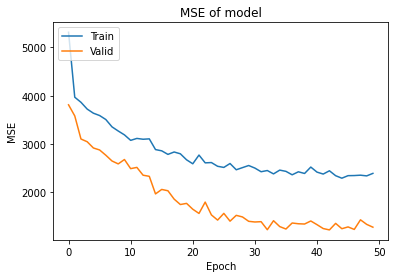

In [ ]:
plt.plot(train_attempt.history["mse"])
plt.plot(train_attempt.history["val_mse"])
plt.title("MSE of model")
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.legend(["Train","Valid"],loc="upper left")
plt.show()

# plt.plot(train_attempt.history["loss"])
# plt.plot(train_attempt.history["val_loss"])
# plt.title("Model loss")
# plt.ylabel("loss")
# plt.xlabel("Epoch")
# plt.legend(["Train","Valid"],loc="upper left")
# plt.show()